In [1]:

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools



# Set paths to input and output data
INPUT_DIR = 'audio_sliced'
OUTPUT_DIR = 'spectrograms'

# Print names of 10 WAV files from the input path
parent_list = os.listdir(INPUT_DIR)
for i in range(10):
    print(parent_list[i])

329.wav
301.wav
467.wav
473.wav
315.wav
472.wav
314.wav
300.wav
466.wav
328.wav


In [2]:
data_labels = pd.read_csv('COVAREP_and_depression_data_mean.csv')

patientId = 300
data_labels['PHQ8_Binary'] = data_labels['PHQ8_Binary'].astype(int)
# print(int(data_labels.loc[data_labels['patientId'] == patientId, 'PHQ8_Binary'].values[0]))

labels = data_labels['PHQ8_Binary']

sum(labels)/len(labels)

0.2962962962962963

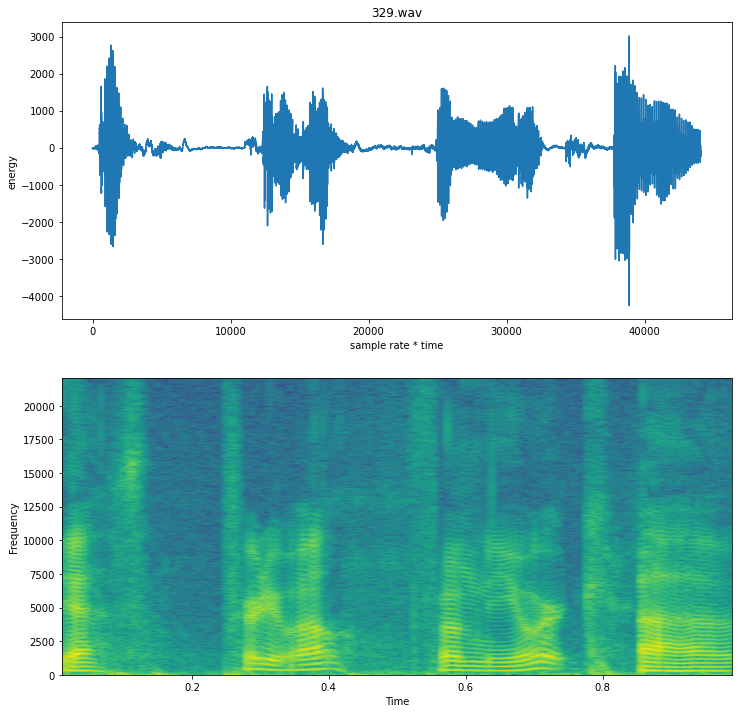

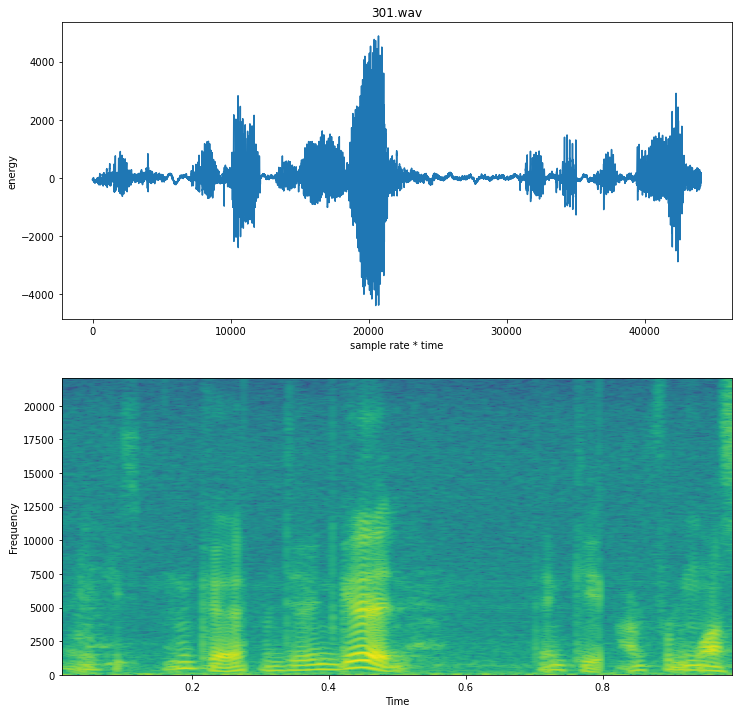

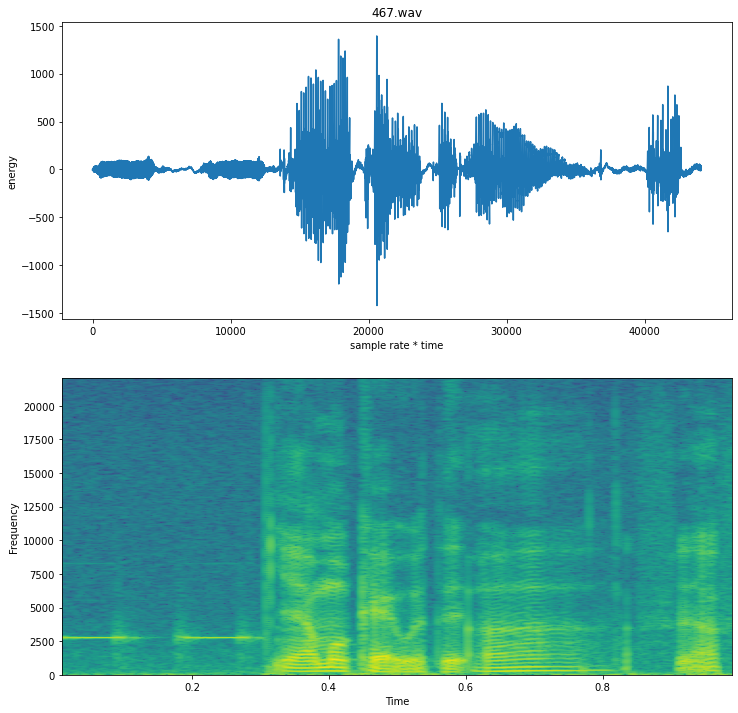

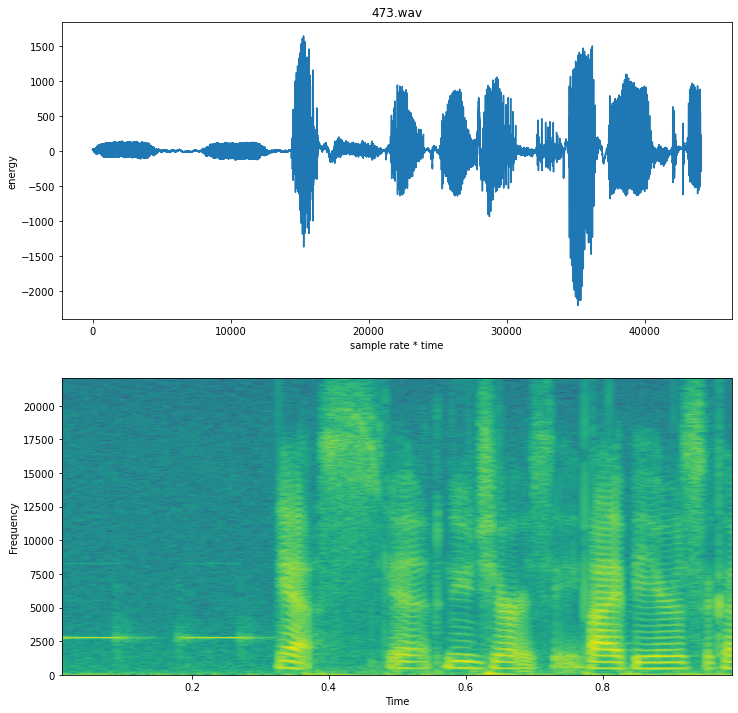

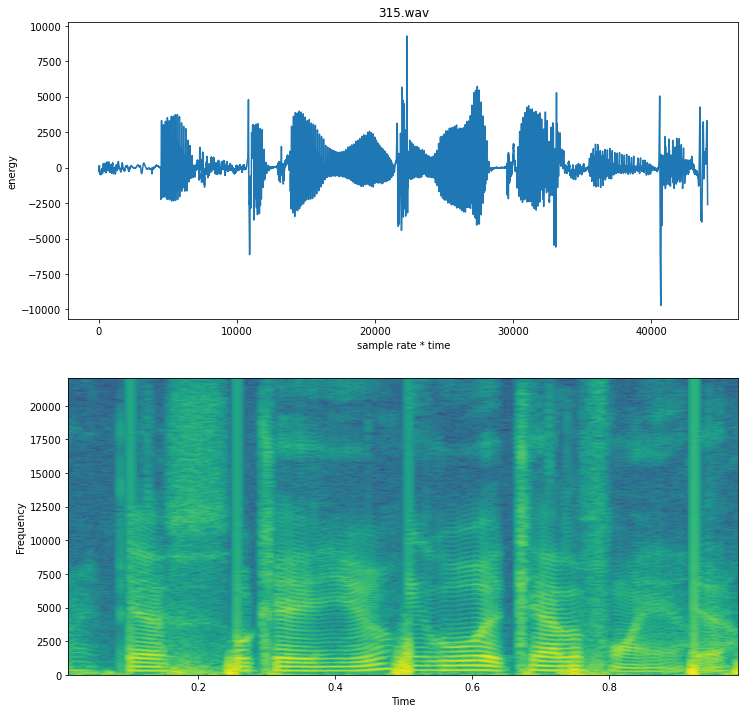

In [18]:
# Plot first 5 WAV files as a waveform and a frequency spectrum
for i in range(5): 
    signal_wave = wave.open(os.path.join(INPUT_DIR, parent_list[i]), 'r')
    sample_rate = 44100
    sig = np.frombuffer(signal_wave.readframes(sample_rate), dtype=np.int16)

    plt.figure(figsize=(12,12))
    plot_a = plt.subplot(211)
    plot_a.set_title(parent_list[i])
    plot_a.plot(sig)
    plot_a.set_xlabel('sample rate * time')
    plot_a.set_ylabel('energy')

    plot_b = plt.subplot(212)
    plot_b.specgram(sig, NFFT=1024, Fs=sample_rate, noverlap=900)
    plot_b.set_xlabel('Time')
    plot_b.set_ylabel('Frequency')

plt.show()

In [3]:
# Utility function to get sound and frame rate info
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.frombuffer(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate

# For every recording, make a spectogram and save it as label_speaker_no.png
if not os.path.exists(os.path.join(OUTPUT_DIR)):
    os.mkdir(os.path.join(OUTPUT_DIR))
    
for filename in os.listdir(INPUT_DIR):
    if "wav" in filename:
        file_path = os.path.join(INPUT_DIR, filename)
        patientId = Path(file_path).stem
        patientIdint = int(patientId)
        label_depression = int(data_labels.loc[data_labels['patientId'] == patientIdint, 'PHQ8_Binary'].values[0])
        target_dir = f'class_{label_depression}'
        dist_dir = os.path.join(os.path.join(OUTPUT_DIR), target_dir)
        file_dist_path = os.path.join(dist_dir, patientId)
        if not os.path.exists(file_dist_path + '.png'):
            if not os.path.exists(dist_dir):
                os.mkdir(dist_dir)
            file_stem = Path(file_path).stem
            sound_info, frame_rate = get_wav_info(file_path)
            pylab.specgram(sound_info, Fs=frame_rate)
            pylab.axis('off')
            pylab.margins(0,0)
            pylab.savefig(f'{file_dist_path}.png', bbox_inches='tight', pad_inches = 0)
            pylab.close()



/Users/bruno/Documents/PsyVox/voice-depression/venv/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7726: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


In [16]:
# Declare constants
IMAGE_HEIGHT = 496
IMAGE_WIDTH = 369
BATCH_SIZE = 20
N_CHANNELS = 3
N_CLASSES = 1
val_split = 0.2
OUTPUT_DIR = 'spectrograms/full/'

# Make a dataset containing the training spectrograms
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(directory = OUTPUT_DIR,
                                             batch_size=BATCH_SIZE,
                                             validation_split=val_split,
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="training",
                                             seed=10)

# Make a dataset containing the validation spectrogram
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(directory = OUTPUT_DIR,
                                             batch_size=BATCH_SIZE,
                                             validation_split=val_split,
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="validation",
                                             seed=10)



Found 189 files belonging to 2 classes.
Using 152 files for training.
Found 189 files belonging to 2 classes.
Using 37 files for validation.


2023-01-25 18:17:38.082652: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


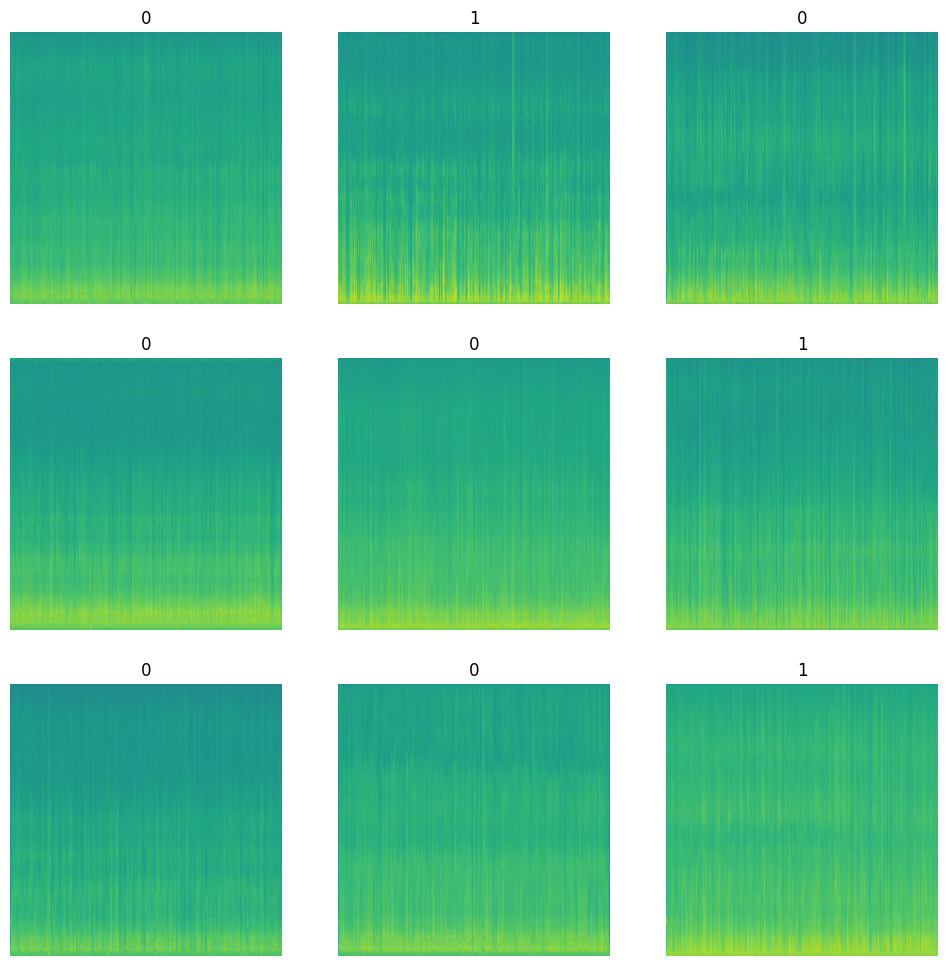

In [6]:
#Let's quickly visualize a few of the generated spectograms and their labels.
plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.show()

In [144]:
# Function to prepare our datasets for modelling
def prepare(ds, augment=False):
    # Define our one transformation
    rescale = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
    # flip_and_rotate = tf.keras.Sequential([
    #     tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    #     tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
    # ])
    
    # Apply rescale to both datasets and augmentation only to training
    ds = ds.map(lambda x, y: (rescale(x, training=True), y))
    if augment: ds = ds.map(lambda x, y: (flip_and_rotate(x, training=True), y))
    return ds

# train_dataset = prepare(train_dataset, augment=False)
# valid_dataset = prepare(valid_dataset, augment=False)

In [62]:
def scheduler(epoch, lr):
  if epoch < 100:
    return lr
  else:
    return lr * tf.math.exp(-0.9)

In [83]:
# Create CNN model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
model.add(tf.keras.layers.Conv2D(2, 2, strides=2, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(64, 64)))
model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(8, activation='relu'))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(N_CLASSES, activation='sigmoid'))

# Compile model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(
    # # from_logits=True,
    label_smoothing=0.2,
    # axis=-1,
    # reduction="auto",
    name="binary_crossentropy",
),
    optimizer= tf.keras.optimizers.Adagrad(learning_rate=0.000001),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None, threshold=0.5), 
            # tf.keras.metrics.AUC(),
            # tf.keras.metrics.Precision(),
            # tf.keras.metrics.Recall(),
            ],
)

model.summary()


Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 248, 185, 2)       26        
                                                                 
 batch_normalization_52 (Bat  (None, 248, 185, 2)      8         
 chNormalization)                                                
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 3, 2, 2)          0         
 g2D)                                                            
                                                                 
 batch_normalization_53 (Bat  (None, 3, 2, 2)          8         
 chNormalization)                                                
                                                                 
 flatten_32 (Flatten)        (None, 12)                0         
                                                     

In [84]:
# Train model for 10 epochs, capture the history
class_weights = {
  0: 0.30,
  1: 0.70,
}

# callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

history = model.fit(train_dataset, epochs=300, validation_data=valid_dataset, class_weight=class_weights)

Epoch 1/300
8/8 [==============================] - 1s 53ms/step - loss: 0.2919 - binary_accuracy: 0.3289 - val_loss: 0.6931 - val_binary_accuracy: 0.7297
Epoch 2/300
8/8 [==============================] - 0s 43ms/step - loss: 0.2919 - binary_accuracy: 0.5526 - val_loss: 0.6931 - val_binary_accuracy: 0.7297
Epoch 3/300
8/8 [==============================] - 0s 44ms/step - loss: 0.2919 - binary_accuracy: 0.6974 - val_loss: 0.6931 - val_binary_accuracy: 0.7297
Epoch 4/300
8/8 [==============================] - 0s 44ms/step - loss: 0.2919 - binary_accuracy: 0.6184 - val_loss: 0.6931 - val_binary_accuracy: 0.7297
Epoch 5/300
8/8 [==============================] - 0s 44ms/step - loss: 0.2919 - binary_accuracy: 0.6974 - val_loss: 0.6931 - val_binary_accuracy: 0.7297
Epoch 6/300
8/8 [==============================] - 0s 45ms/step - loss: 0.2919 - binary_accuracy: 0.6974 - val_loss: 0.6931 - val_binary_accuracy: 0.7297
Epoch 7/300
8/8 [==============================] - 0s 44ms/step - loss: 0.29

KeyboardInterrupt: 

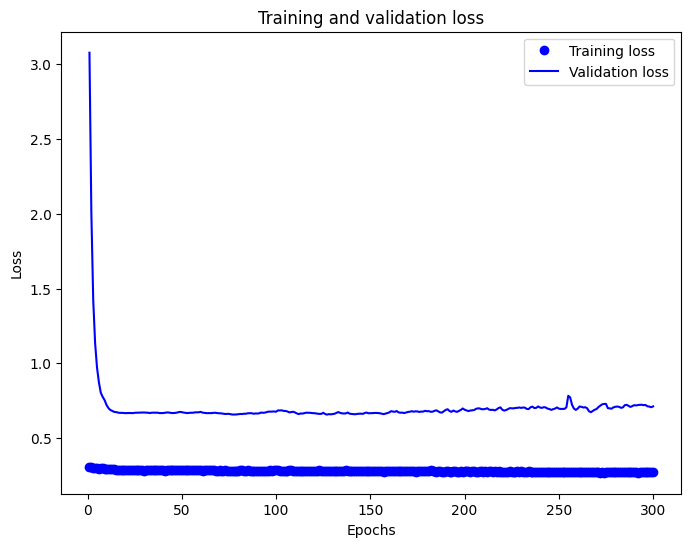

In [59]:
# Plot the loss curves for training and validation.
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [172]:
# Compute the final loss and accuracy
final_loss, final_acc = model.evaluate(valid_dataset, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.724562, final accuracy: 0.702703


In [173]:
model.predict(valid_dataset)

4/4 [==============================] - 0s 12ms/step


array([[0.43595335],
       [0.6654711 ],
       [0.6652519 ],
       [0.56300753],
       [0.42415783],
       [0.3241044 ],
       [0.44152555],
       [0.42839524],
       [0.1889997 ],
       [0.65496135],
       [0.03502619],
       [0.17630638],
       [0.13232929],
       [0.18745044],
       [0.7614728 ],
       [0.6654711 ],
       [0.618589  ],
       [0.00612976],
       [0.36123094],
       [0.03193557],
       [0.05576873],
       [0.39415658],
       [0.57156974],
       [0.7677764 ],
       [0.13326061],
       [0.43132144],
       [0.14886762],
       [0.14723746],
       [0.09060252],
       [0.05939097],
       [0.44152555],
       [0.39415658],
       [0.13232929],
       [0.0200484 ],
       [0.21860632],
       [0.23365258],
       [0.08124918]], dtype=float32)